# `gymnax`: Classic Gym Environments in JAX
### [Last Update: June 2022][![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RobertTLange/gymnax/blob/main/examples/getting_started.ipynb)

Welcome to `gymnax`, the one stop shop for fast classic Reinforcement Learning environments powered by JAX.

In [19]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

# !pip install -q git+https://github.com/RobertTLange/gymnax.git@main

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Basic API: `gymnax.make()`, `env.reset()`, `env.step()`

In [20]:
import os

# Set the number of (emulated) host devices
num_devices = 1
os.environ['XLA_FLAGS'] = f"--xla_force_host_platform_device_count={num_devices} --xla_gpu_autotune_level=0"

import jax
import jax.numpy as jnp
import gymnax

jax.device_count(), jax.devices()

(1, [CpuDevice(id=0)])

In [21]:
rng = jax.random.PRNGKey(0)
rng, key_reset, key_policy, key_step = jax.random.split(rng, 4)

# Create the Pendulum-v1 environment
env, env_params = gymnax.make("Pendulum-v1")

# Inspect default environment settings
env_params

EnvParams(max_steps_in_episode=200, max_speed=8.0, max_torque=2.0, dt=0.05, g=10.0, m=1.0, l=1.0)

You can get an overview of all implemented environments as follows:

In [22]:
gymnax.registered_envs

['CartPole-v1',
 'Pendulum-v1',
 'Acrobot-v1',
 'MountainCar-v0',
 'MountainCarContinuous-v0',
 'Asterix-MinAtar',
 'Breakout-MinAtar',
 'Freeway-MinAtar',
 'SpaceInvaders-MinAtar',
 'Catch-bsuite',
 'DeepSea-bsuite',
 'MemoryChain-bsuite',
 'UmbrellaChain-bsuite',
 'DiscountingChain-bsuite',
 'MNISTBandit-bsuite',
 'SimpleBandit-bsuite',
 'FourRooms-misc',
 'MetaMaze-misc',
 'PointRobot-misc',
 'BernoulliBandit-misc',
 'GaussianBandit-misc',
 'Reacher-misc',
 'Swimmer-misc',
 'Pong-misc']

In [23]:
obs, state = env.reset(key_reset, env_params)
obs, state

(Array([-0.99895006, -0.04581222, -0.9582176 ], dtype=float32),
 EnvState(time=Array(0, dtype=int32, weak_type=True), theta=Array(-3.0957644, dtype=float32), theta_dot=Array(-0.9582176, dtype=float32), last_u=Array(0., dtype=float32, weak_type=True)))

In [24]:
action = env.action_space(env_params).sample(key_policy)
n_obs, n_state, reward, done, _ = env.step(key_step, state, action, env_params)
n_obs, n_state, reward, done

(Array([-0.9999658, -0.0082727, -0.7511071], dtype=float32),
 EnvState(time=Array(1, dtype=int32, weak_type=True), theta=Array(-3.1333199, dtype=float32), theta_dot=Array(-0.7511071, dtype=float32), last_u=Array(1.609798, dtype=float32)),
 Array(-9.678166, dtype=float32),
 Array(False, dtype=bool, weak_type=True))

You can also simply use the environment with its default settings:

In [25]:
obs, state = env.reset(key_reset)
action = env.action_space().sample(key_policy)
n_obs, n_state, reward, done, _ = env.step(key_step, state, action)

`gymnax` provides fully functional environment dynamics that can leverage the full power of JAX's function transformations. E.g. one common RL use-case the parallel rollout of multiple workers. Using a `vmap` across random seeds (one per worker) allows us to implement such a parallelization on a single machine:

In [26]:
vmap_reset = jax.vmap(env.reset, in_axes=(0, None))
vmap_step = jax.vmap(env.step, in_axes=(0, 0, 0, None))

num_envs = 8
vmap_keys = jax.random.split(rng, num_envs)

obs, state = vmap_reset(vmap_keys, env_params)
n_obs, n_state, reward, done, _ = vmap_step(vmap_keys, state, jnp.zeros(num_envs), env_params)
print(n_obs.shape)

(8, 3)


Similarly, you can also choose to `pmap` across rollout workers ("actors") across multiple devices:

In [27]:
pmap_reset = jax.pmap(env.reset, in_axes=(0, None))
pmap_step = jax.vmap(env.step, in_axes=(0, 0, 0, None))


pmap_keys = jax.random.split(rng, num_devices)
obs, state = pmap_reset(pmap_keys, env_params)
n_obs, n_state, reward, done, _ = pmap_step(pmap_keys, state, jnp.zeros(num_devices), env_params)
print(n_obs.shape)

(1, 3)


The code above has executed each worker-specific environment transition on a separate device, but we can also chain `vmap` and `pmap` to execute multiple workers on a single device and at the same time across multiple devices:

In [28]:
map_reset = jax.pmap(vmap_reset, in_axes=(0, None))
map_step = jax.pmap(vmap_step, in_axes=(0, 0, 0, None))

map_keys = jnp.tile(vmap_keys, (num_devices, 1, 1))
obs, state = map_reset(map_keys, env_params)
n_obs, n_state, reward, done, _ = map_step(map_keys, state, jnp.zeros((num_devices, num_envs)), env_params)
print(n_obs.shape)

(1, 8, 3)


We can now easily leverage massive accelerator parallelism to churn through millions/billions of environment transitions when training 'sentient' agents. Note that in the code snippet above we have executed 4 times the same 8 environment workers, since we tiled/repeated the same key across the device axis. In general `pmap`-ing will require you to pay special attention to the shapes of the arrays that come out your operations.

## Jitted Episode Rollouts via `lax.scan`

Let's now walk through an example of using `gymnax` with one of the common neural network libraries to parametrize a simple policy: `flax`. 

In [29]:
from flax import linen as nn


class MLP(nn.Module):
    """Simple ReLU MLP."""

    num_hidden_units: int
    num_hidden_layers: int
    num_output_units: int

    @nn.compact
    def __call__(self, x, rng):
        for l in range(self.num_hidden_layers):
            x = nn.Dense(features=self.num_hidden_units)(x)
            x = nn.relu(x)
        x = nn.Dense(features=self.num_output_units)(x)
        return x
    

model = MLP(48, 1, 1)
policy_params = model.init(rng, jnp.zeros(3), None)

In [30]:
def rollout(rng_input, policy_params, env_params, steps_in_episode):
    """Rollout a jitted gymnax episode with lax.scan."""
    # Reset the environment
    rng_reset, rng_episode = jax.random.split(rng_input)
    obs, state = env.reset(rng_reset, env_params)

    def policy_step(state_input, tmp):
        """lax.scan compatible step transition in jax env."""
        obs, state, policy_params, rng = state_input
        rng, rng_step, rng_net = jax.random.split(rng, 3)
        action = model.apply(policy_params, obs, rng_net)
        next_obs, next_state, reward, done, _ = env.step(
          rng_step, state, action, env_params
        )
        carry = [next_obs, next_state, policy_params, rng]
        return carry, [obs, action, reward, next_obs, done]

    # Scan over episode step loop
    _, scan_out = jax.lax.scan(
      policy_step,
      [obs, state, policy_params, rng_episode],
      (),
      steps_in_episode
    )
    # Return masked sum of rewards accumulated by agent in episode
    obs, action, reward, next_obs, done = scan_out
    return obs, action, reward, next_obs, done

In [31]:
# Jit-Compiled Episode Rollout
jit_rollout = jax.jit(rollout, static_argnums=3)
obs, action, reward, next_obs, done = jit_rollout(rng, policy_params, env_params, 200)
obs.shape, reward.shape, jnp.sum(reward)

((200, 3), (200,), Array(-1607.6074, dtype=float32))

Again, you can wrap this `rollout` function with the magic of JAX and for all implemented RL environments. But we also provide a simple that does so for you:

In [32]:
from gymnax.experimental import RolloutWrapper

# Define rollout manager for pendulum env
manager = RolloutWrapper(model.apply, env_name="Pendulum-v1")

# Simple single episode rollout for policy
obs, action, reward, next_obs, done, cum_ret = manager.single_rollout(rng, policy_params)

In [33]:
# Multiple rollouts for same network (different rng, e.g. eval)
rng_batch = jax.random.split(rng, 10)
obs, action, reward, next_obs, done, cum_ret = manager.batch_rollout(
    rng_batch, policy_params
)

# Multiple rollouts for different networks + rng (e.g. for ES)
batch_params = jax.tree_map(  # Stack parameters or use different
    lambda x: jnp.tile(x, (5, 1)).reshape(5, *x.shape), policy_params
)
obs, action, reward, next_obs, done, cum_ret = manager.population_rollout(
    rng_batch, batch_params
)

## Visualizing Episode Rollouts

AssertionError: 

Error in callback <function _draw_all_if_interactive at 0x712019f5fb00> (for post_execute), with arguments args (),kwargs {}:


AssertionError: 

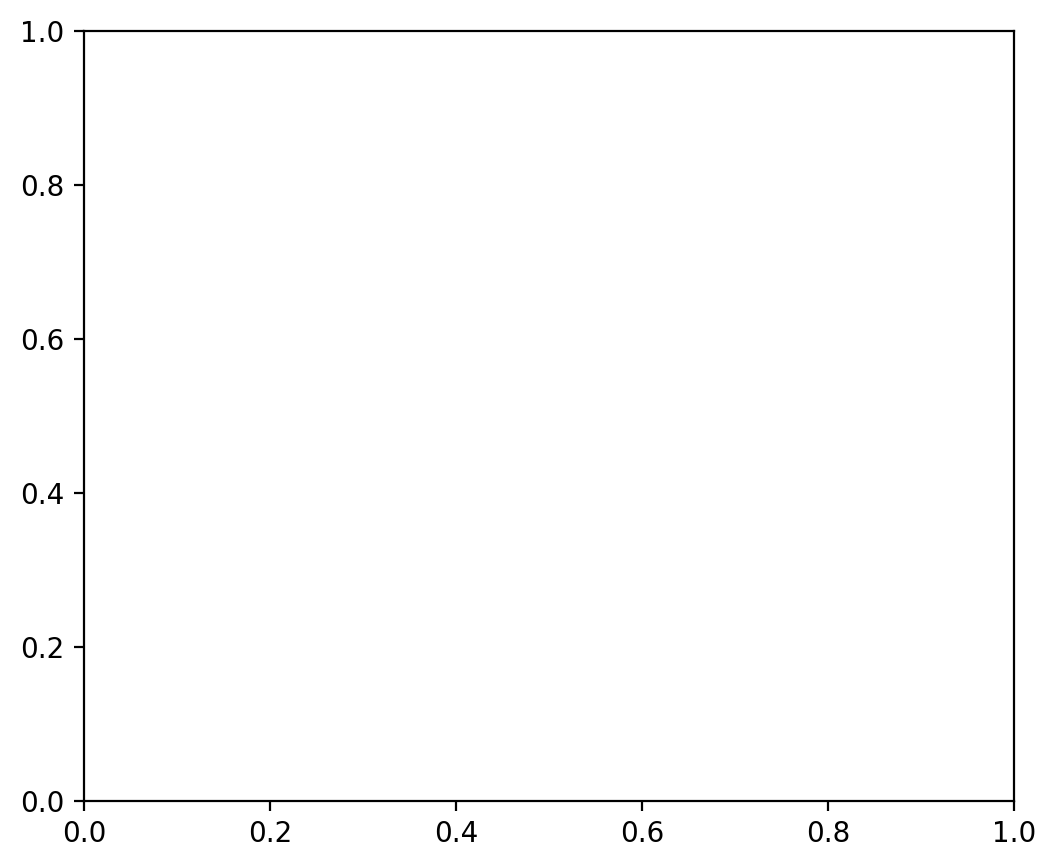

In [34]:
from gymnax.visualize import Visualizer

state_seq, reward_seq = [], []
rng, rng_reset = jax.random.split(rng)
obs, env_state = env.reset(rng_reset, env_params)
t_counter = 0
while True:
    state_seq.append(env_state)
    rng, rng_act, rng_step = jax.random.split(rng, 3)
    action = env.action_space(env_params).sample(rng_act)
    next_obs, next_env_state, reward, done, info = env.step(
        rng_step, env_state, action, env_params
    )
    reward_seq.append(reward)
    t_counter += 1
    if done or t_counter >= 50:
        break
    else:
        obs = next_obs
        env_state = next_env_state

cum_rewards = jnp.cumsum(jnp.array(reward_seq))
vis = Visualizer(env, env_params, state_seq, cum_rewards)
vis.animate(f"anim.gif")

In [ ]:
from IPython.display import Image
Image(url='docs/anim.gif')  